In [1]:
from copy import deepcopy

from models import StrideLSTM
from dataset import StrideDataset
from load_data import load_data_from_folder, integrate_ankle_insole
import torch
from torch.utils.data import DataLoader
from torch import nn
from load_data import process_camargo_data, normalize_ankle_angle

In [13]:
train_data_path = "./data/12_11_treadmill_walk_2min/"
cutoff_start = 50
cutoff_end = 180
moticon_offset = 19.6934
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
sequence_len = 100

In [3]:
camargo_ds = process_camargo_data("camargo/data/", load_portion=1)

Processing camargo:   0%|          | 0/1237 [00:00<?, ?it/s]

In [11]:
pretrain_ds = [StrideDataset(normalize_ankle_angle(data), sequence_length=sequence_len) for data in camargo_ds]
pretrain_pos_weight = sum([sum(ds.labels == 0) for ds in pretrain_ds]) / sum([sum(ds.labels == 1) for ds in pretrain_ds])
batch_size = 1024
# combine all datasets
pretrain_ds = torch.utils.data.ConcatDataset(pretrain_ds)
num_samples = len(pretrain_ds)
num_train_samples = int(0.8 * num_samples)
pretrain_train, pretrain_val = torch.utils.data.random_split(pretrain_ds, [num_train_samples, num_samples - num_train_samples])
pretrain_loader = DataLoader(pretrain_train, batch_size=batch_size)
pretrain_val_loader = DataLoader(pretrain_val, batch_size=batch_size)
print("Pretraining train size:", len(pretrain_train))
print("Pretraining val size:", len(pretrain_val))

Pretraining train size: 701794
Pretraining val size: 175449


In [14]:
# ankle_data, insole_data, _ = load_data_from_folder(train_data_path, cutoff_start, cutoff_end, 0, moticon_offset)
# ankle_data, insole_data, _ = load_data_from_folder("./data/01_16_up_down_stairs/", 16, 140, 0, 14.4)
# walk outside
ankle_data, insole_data, _ = load_data_from_folder("data/04_03_walk/", [0], [149], 0, 30.5731)
integrate_ankle_insole(ankle_data, insole_data)
ankle_data = normalize_ankle_angle(ankle_data)

dataset = StrideDataset(ankle_data, sequence_length=sequence_len)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(f'Train size: {train_size}, Validation size: {val_size}')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print("Initializing Model")
input_size = 7  # 3 (accel) * 2 + 1 (ankle angle)

val_loader = DataLoader(val_dataset, batch_size=32)
train_loader = DataLoader(train_dataset,batch_size=32)

Train size: 5725, Validation size: 1432
Initializing Model


In [15]:
def vote_activity(imu_data):
    activities = [data.activity for data in imu_data]
    activity_counts = {activity: activities.count(activity) for activity in set(activities)}
    # sort by count
    sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)
    # return the most common activity that is not idle
    for activity, count in sorted_activities:
        if activity != "idle" and '-' not in activity and activity != "stand":
            return activity

activity: walk


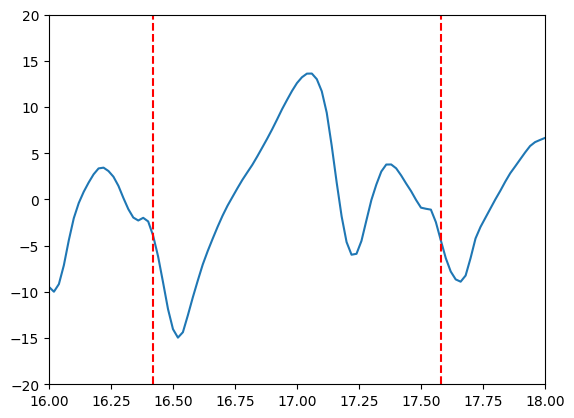

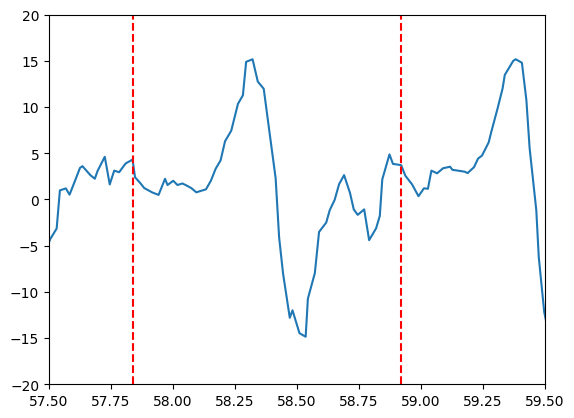

In [16]:
# visualize pretrain data ankle angle vs force
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import random

def visualize_data(ds, xlim=None, mult=1):
    # get all samples' ankle angles and forces
    integrate_ankle_insole(ds)
    ankle_angles = [mult*data.get_ankle_angle() for data in ds]
    imu_0_x = [data.accel1[2]*mult for data in ds]
    times = [data.timestep for data in ds]
    # smooth the ankle angles
    ankle_angles = np.array(ankle_angles)
    times = np.array(times)
    window_size = 10
    polyorder = 3
    ankle_angles = savgol_filter(ankle_angles, window_size, polyorder)
    plt.plot(times, ankle_angles)
    plt.ylim([-20, 20])
    # ax2 = plt.twinx()
    # ax2.plot(times, imu_0_x, color='r')
    # ax2.set_ylabel("Force (N)")
    # ax2.set_ylim([-30, 20])
    # plot heel strikes
    heel_strikes = [data.timestep for data in ds if data.heel_striking]
    for time in heel_strikes:
        plt.axvline(x=time, color='r', linestyle='--')
    # plot ankle angles
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
selector = 20
print(f"activity: {vote_activity(camargo_ds[selector])}")
visualize_data(camargo_ds[selector],xlim=[16, 18], mult=1)
visualize_data(ankle_data, xlim=[57.5, 59.5])

In [17]:
model = StrideLSTM(input_size=input_size, hidden_size=128, num_layers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs = []
val_accs = []
model.to(device)

StrideLSTM(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Softmax(dim=1)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [18]:
# load model
model.load_state_dict(torch.load('stride_segmentation.pth'))

/tmp/ipykernel_3189/844683735.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/stride_lstm.pth'))


<All keys matched successfully>

In [ ]:
# Define the loss function with class weights
print(f"Pretraining pos weight: {pretrain_pos_weight}")
class_weights = torch.tensor([1.0, pretrain_pos_weight], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# pretraining loop
num_epochs = 20
from tqdm.auto import tqdm
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(pretrain_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_total_true_strikes = 0
    val_total_predicted_strikes = 0

    with torch.no_grad():
        for inputs, labels in pretrain_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_total_true_strikes += (labels == 1).sum().item()
            val_total_predicted_strikes += (predicted == 1).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, total true strikes: {val_total_true_strikes}, total predicted strikes: {val_total_predicted_strikes}')

In [19]:
# Define the loss function with class weights
pos_weight_value = dataset.pos_weight.item()
print(f"Pos weight: {pos_weight_value}")
class_weights = torch.tensor([1.0, pos_weight_value], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
num_epochs = 100
from tqdm.auto import tqdm
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_total_true_strikes = 0
    val_total_predicted_strikes = 0

    with (torch.no_grad()):
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_total_true_strikes += (labels == 1).sum().item()
            val_total_predicted_strikes += (predicted == 1).sum().item()


    val_loss /= val_total
    val_acc = val_correct / val_total
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, total true strikes: {val_total_true_strikes}, total predicted strikes: {val_total_predicted_strikes}')

Pos weight: 0.5886792540550232


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] | Train Loss: 0.1277, Acc: 0.9572 | Val Loss: 0.0656, Acc: 0.9693, total true strikes: 898, total predicted strikes: 870
Epoch [2/100] | Train Loss: 0.0852, Acc: 0.9654 | Val Loss: 0.0503, Acc: 0.9791, total true strikes: 898, total predicted strikes: 896
Epoch [3/100] | Train Loss: 0.0835, Acc: 0.9652 | Val Loss: 0.0697, Acc: 0.9658, total true strikes: 898, total predicted strikes: 881
Epoch [4/100] | Train Loss: 0.0774, Acc: 0.9642 | Val Loss: 0.0469, Acc: 0.9791, total true strikes: 898, total predicted strikes: 888
Epoch [5/100] | Train Loss: 0.0833, Acc: 0.9644 | Val Loss: 0.0847, Acc: 0.9686, total true strikes: 898, total predicted strikes: 883
Epoch [6/100] | Train Loss: 0.0786, Acc: 0.9673 | Val Loss: 0.0597, Acc: 0.9735, total true strikes: 898, total predicted strikes: 882
Epoch [7/100] | Train Loss: 0.0723, Acc: 0.9672 | Val Loss: 0.0511, Acc: 0.9791, total true strikes: 898, total predicted strikes: 882


KeyboardInterrupt: 

In [20]:
# Save the model
torch.save(model.state_dict(), 'stride_segmentation.pth')

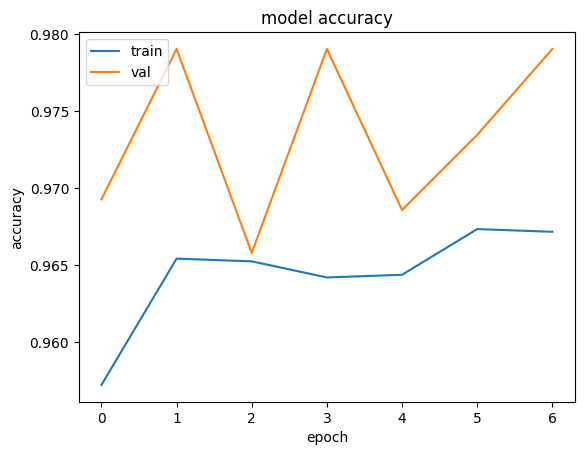

In [21]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
import numpy as np
from tqdm import tqdm

# plotting_data, _, _ = load_data_from_folder("data/past_test/", 39, 160, 0, moticon_offset)
# for data in plotting_data:
#     if data.fsr_voltage > 0.02:
#         data.force = 300
# integrate_ankle_insole(plotting_data)

# upstairs
# plotting_data, insole_data, _ = load_data_from_folder("data/01_22_upstairs/", 0, 1e9, 0, 2.55)
# integrate_ankle_insole(plotting_data, insole_data)

# downstairs
# plotting_data, insole_data, _ = load_data_from_folder("data/01_22_downstairs/", 20, 1e9, 0, 0.34)
# integrate_ankle_insole(plotting_data, insole_data)

# upramp
# plotting_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [23,62], [34,71], 0, -0.90)
# integrate_ankle_insole(plotting_data, insole_data)

# downramp
# plotting_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [10,43], [20,55], 0, -0.90)
# integrate_ankle_insole(plotting_data, insole_data)

# walk outside
# plotting_data, insole_data, _ = load_data_from_folder("data/04_03_walk/", [159], [202], 0, 30.6)
# integrate_ankle_insole(plotting_data, insole_data)

plotting_data = normalize_ankle_angle(plotting_data)
# infer the ankle angles on the plotting data
def evaluate_model(model, ankle_data, device, sequence_length=100):
    # Create full dataset without splits
    full_dataset = StrideDataset(ankle_data, sequence_length=sequence_length)
    eval_loader = DataLoader(full_dataset, batch_size=128, shuffle=False)

    # Initialize arrays to store predictions and ground truth
    total_timesteps = len(ankle_data)
    all_predictions = np.full(total_timesteps, -1, dtype=np.int64)  # -1 = no prediction
    all_labels = np.full(total_timesteps, -1, dtype=np.int64)

    model.eval()
    current_position = sequence_length//2

    with torch.no_grad():
        for batch_features, batch_labels in tqdm(eval_loader):
            batch_features = batch_features.to(device)

            # Make predictions
            outputs = model(batch_features)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()

            # Store predictions and labels
            batch_size = len(batch_preds)
            end_position = current_position + batch_size
            all_predictions[current_position:end_position] = batch_preds
            all_labels[current_position:end_position] = batch_labels.numpy()

            current_position = end_position

    return all_predictions, all_labels

# Evaluate the model
predictions, labels = evaluate_model(model, plotting_data, sequence_length=sequence_len, device=device)
print(f"True Strikes: {np.sum(labels == 1)}")
print(f"Predicted Strikes: {np.sum(predictions == 1)}")

gt_data = deepcopy(plotting_data)
# remove force data
for data in plotting_data:
    data.force = 0
for data, prediction in zip(plotting_data, predictions):
    data.force = 300 if prediction == 1 else 0

integrate_ankle_insole(plotting_data)

heel_striking_times = [data.timestep for data in plotting_data if data.heel_striking]
gt_heel_striking_times = [data.timestep for data in gt_data if data.heel_striking]

# for each gt heel striking time, find the closest predicted heel striking time
predicted_heel_striking_times = []
for gt_time in gt_heel_striking_times:
    closest_time = min(heel_striking_times, key=lambda x: abs(x - gt_time))
    predicted_heel_striking_times.append(closest_time)
print(f"Average Error: {np.mean(np.abs(np.array(predicted_heel_striking_times) - np.array(gt_heel_striking_times)))}s")
print(f"# of Predicted Heel Strikes: {len(predicted_heel_striking_times)}, # of GT Heel Strikes: {len(gt_heel_striking_times)}")
print(f"Predicted Heel Strikes: {heel_striking_times}")
print(f"GT Heel Strikes: {gt_heel_striking_times}")
print(np.abs(np.array(predicted_heel_striking_times) - np.array(gt_heel_striking_times)))

100%|██████████| 52/52 [00:00<00:00, 111.07it/s]


True Strikes: 4944
Predicted Strikes: 4966
Average Error: 0.22494117647058723s
# of Predicted Heel Strikes: 51, # of GT Heel Strikes: 51
Predicted Heel Strikes: [21.004, 26.286, 27.71, 29.122, 30.403, 31.727, 31.829, 38.591, 38.78, 39.924, 41.098, 46.96, 48.353, 48.842, 49.63, 50.02, 50.852, 52.283, 53.68, 62.694, 64.073, 71.44, 72.766, 73.905, 74.511, 75.303, 76.483, 86.976, 92.194, 93.418, 94.691, 95.115, 96.096, 97.494, 98.894, 107.901, 113.571, 114.806, 116.06, 117.378, 118.588, 119.94, 130.241, 131.289, 138.164, 139.431, 140.765, 142.03, 143.332, 144.74, 146.063, 147.675]
GT Heel Strikes: [26.262, 27.687, 29.061, 30.361, 31.883, 38.551, 39.958, 41.231, 46.918, 48.244, 49.575, 50.876, 52.269, 53.794, 61.397, 62.722, 64.088, 71.44, 72.671, 73.905, 75.285, 76.722, 85.569, 86.965, 88.331, 92.089, 93.331, 94.678, 96.059, 97.469, 99.128, 106.45, 107.901, 109.363, 113.497, 114.735, 116.005, 117.319, 118.56, 120.112, 128.859, 130.28, 131.7, 138.096, 139.385, 140.686, 142.019, 143.317, 144

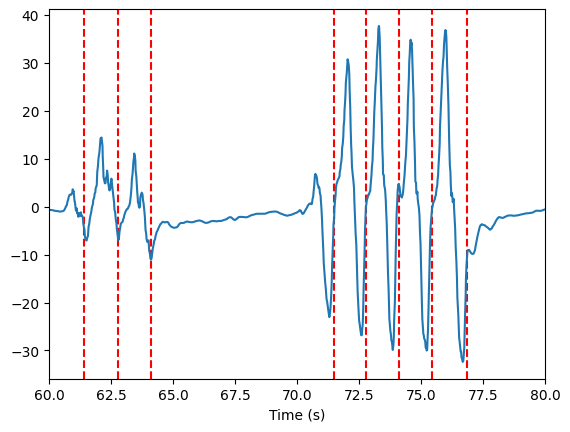

In [13]:
# plot ankle angle over time
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
ankle_angles = [data.get_ankle_angle() for data in plotting_data]
times = [data.timestep for data in plotting_data]
# smooth the ankle angles
ankle_angles = np.array(ankle_angles)
times = np.array(times)
window_size = 10
polyorder = 3
ankle_angles = savgol_filter(ankle_angles, window_size, polyorder)

# vertical line at heel lifting
heel_striking_times = [data.timestep for data in plotting_data if data.heel_striking]
for time in heel_striking_times:
    plt.axvline(x=time, color='r', linestyle='--')

# plot fsr voltage
# ax2 = plt.twinx()
# fsr_voltage = [data.fsr_voltage for data in plotting_data]
# ax2.plot(times, fsr_voltage, color='g')
# ax2.set_ylabel("FSR Voltage (V)")

plt.plot(times, ankle_angles)
plt.xlabel('Time (s)')
# plt.ylabel('Ankle Angle (degrees)')
plt.xlim([60, 80])
plt.show()

In [14]:
class Segment:
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
        self.data = []

    def add_data(self, data):
        self.data.append(data)
        if self.start_time == 0:
            self.start_time = data.timestep
        self.end_time = data.timestep

    def interval(self):
        return self.end_time - self.start_time

In [15]:
segments = []
current_segment = Segment()
for data in plotting_data:
    if data.heel_striking:
        if current_segment.data:
            segments.append(current_segment)
        current_segment = Segment()
    current_segment.add_data(data)

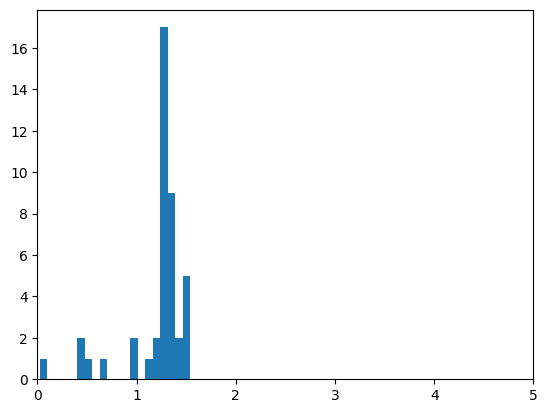

In [16]:
# plot histogram of segment intervals
import matplotlib.pyplot as plt
import numpy as np

segment_intervals = [segment.interval() for segment in segments if segment.interval()<5]

plt.hist(segment_intervals, bins=20)
plt.xlim([0, 5])
# plot max ankle angle difference for each segment
ankle_angles = [[x.get_ankle_angle() for x in segment.data] for segment in segments]
ankle_angle_diffs = [max(angles) - min(angles) for angles in ankle_angles]

Filtered 28 segments


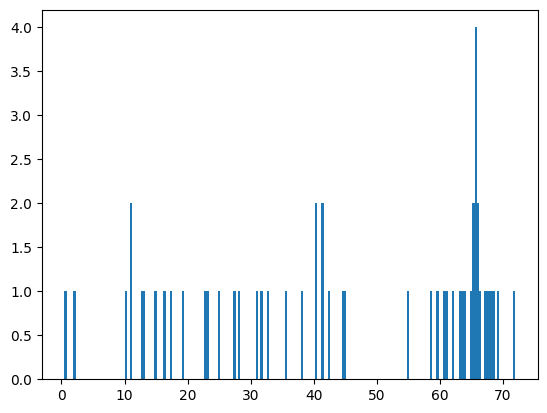

In [17]:
plt.hist(ankle_angle_diffs, bins=200)
# overlay each segment on the ankle angle plot
# time_filter = [1.4, 1.6]
time_filter = [1, 1.5]
filtered_segments = [segment for segment in segments if
                     segment.interval() > time_filter[0] and segment.interval() < time_filter[1]]
# then filter out segments with small ankle angle differences (<20 degrees)
filtered_segments = [segment for segment in filtered_segments if
                     max([data.get_ankle_angle() for data in segment.data]) - min(
                         [data.get_ankle_angle() for data in segment.data]) > 30]
# filtered_segments = segments
print(f"Filtered {len(filtered_segments)} segments")

In [18]:

# normalize the time axis to % stride
for segment in filtered_segments:
    segment_interval = segment.interval()
    for data in segment.data:
        data.perc_stride = (data.timestep - segment.start_time) / segment_interval * 100

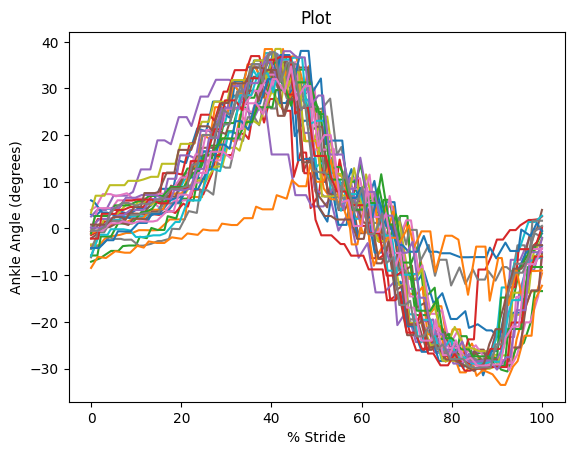

In [19]:

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

ankle_angles = [[x.get_ankle_angle() for x in segment.data] for segment in filtered_segments]

# overlay each segment on the ankle angle plot
fig, ax1 = plt.subplots()
for angles in ankle_angles[:]:
    perc_stride = [data.perc_stride for data in filtered_segments[ankle_angles.index(angles)].data]
    ax1.plot(perc_stride, angles)
ax1.set_ylabel("Ankle Angle (degrees)")
plt.xlabel("% Stride")
plt.title("Plot")
plt.show()

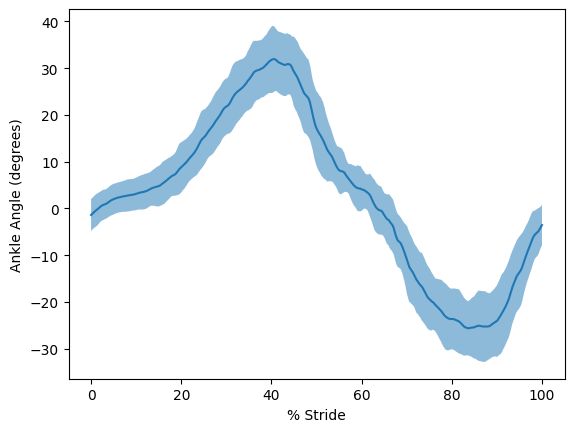

In [20]:
# plot mean and std ankle angle as a whole for all segments
# linear interpolate for 1000 datapoints per segment
import numpy as np
from scipy.interpolate import interp1d

interp_angles = []
for segment in filtered_segments:
    interp_angles.append(
        interp1d([data.perc_stride for data in segment.data], [data.get_ankle_angle() for data in segment.data],
                 kind='linear'))
stride = np.linspace(0, 100, 1000)
angles = [angle(stride) for angle in interp_angles]
angles = np.array(angles)
mean = np.mean(angles, axis=0)
std = np.std(angles, axis=0)
plt.plot(stride, mean)
plt.fill_between(stride, mean - std, mean + std, alpha=0.5)
plt.ylabel("Ankle Angle (degrees)")
plt.xlabel("% Stride")
plt.show()
# shift data by 50% stride
# shifted_angles = []
# plt.figure(figsize=(6, 5))
# shift_by = 60
# for angle in angles:
#     # shifted_angles.append(np.roll(angle, 800))
#     shifted_angles.append(np.roll(angle, int(shift_by / 100 * 1000)) - 50)
# shifted_angles = np.array(shifted_angles)
# mean = np.mean(shifted_angles, axis=0)
# std = np.std(shifted_angles, axis=0)
# plt.plot(stride, mean)
# plt.fill_between(stride, mean - std, mean + std, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='-')
# # vertical line at shift_by
# # plt.axvline(x=shift_by, color='r', linestyle='--')
# # plot -40 to 40
# plt.ylim(-35, 35)
#
# plt.ylabel("Ankle Angle (degrees)")
# plt.xlabel("% Stride")
# plt.title("Walk")
# plt.show()